# LIBRARIES

In [113]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

# DISPLAY


In [19]:
pd.set_option("display.max_columns",None)

In [20]:
sklearn.set_config(transform_output="pandas")

In [21]:
path="/Users/karthik/Desktop/SAGEMAKER/DATASET/train.csv"


In [22]:
train=pd.read_csv(path)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [24]:
train.describe()

,duration,total_stops,price
count,640.00000,640.000000,640.000000
mean,594.15625,0.770312,8973.889063
std,492.48594,0.682025,4668.581499
min,75.00000,0.000000,1965.000000
25%,170.00000,0.000000,4990.750000
50%,437.50000,1.000000,8073.000000
75%,845.00000,1.000000,12397.000000
max,2295.00000,4.000000,36235.000000


In [25]:
X=train.drop("price",axis=1)

In [58]:
Y=train["price"]

# transformation

In [27]:
X.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

In [28]:
X.airline

0           Indigo
1      Jet Airways
2         Spicejet
3        Air India
4      Jet Airways
          ...     
635         Indigo
636    Jet Airways
637         Indigo
638         Indigo
639         Indigo
Name: airline, Length: 640, dtype: object

In [29]:
air_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
]
                        )
                         

In [30]:
air_transformer.fit_transform(X.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Spicejet,airline_other
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0,0.0
637,0.0,1.0,0.0,0.0,0.0,0.0
638,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
X.date_of_journey

0      2019-06-24
1      2019-05-21
2      2019-05-27
3      2019-06-06
4      2019-05-15
          ...    
635    2019-06-24
636    2019-05-21
637    2019-04-15
638    2019-05-15
639    2019-03-18
Name: date_of_journey, Length: 640, dtype: object

In [35]:
feature_to_extract=["month","week","day_of_week","day_of_year"]

doj_transformer=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_to_extract , yearfirst=True,format="mixed")),
    ("scaler",MinMaxScaler())
])
doj_transformer.fit_transform(X.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,1.000000,0.000000,0.974576
1,0.666667,0.705882,0.166667,0.686441
2,0.666667,0.764706,0.000000,0.737288
3,1.000000,0.823529,0.500000,0.822034
4,0.666667,0.647059,0.333333,0.635593
...,...,...,...,...
635,1.000000,1.000000,0.000000,0.974576
636,0.666667,0.705882,0.166667,0.686441
637,0.333333,0.411765,0.000000,0.381356
638,0.666667,0.647059,0.333333,0.635593


In [41]:
X.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

In [43]:
location_subset=X.loc[:,["source","destination"]]

In [44]:
location_subset

,source,destination
0,Banglore,Delhi
1,Kolkata,Banglore
2,Mumbai,Hyderabad
3,Kolkata,Banglore
4,Kolkata,Banglore
...,...,...
635,Kolkata,Banglore
636,Delhi,Cochin
637,Delhi,Cochin
638,Banglore,Delhi


In [63]:
location_pipe1=Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoder",MeanEncoder()),
    ("power",PowerTransformer())
])

In [65]:
location_pipe1.fit_transform(location_subset,Y)

,source,destination
0,-0.866320,-1.745515
1,-0.220682,-0.256758
2,-1.865999,-0.613686
3,-0.220682,-0.256758
4,-0.220682,-0.256758
...,...,...
635,-0.220682,-0.256758
636,1.097820,1.088781
637,1.097820,1.088781
638,-0.866320,-1.745515


In [67]:
np.union1d(
	X.source.unique(),
	X.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [72]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,0,1


In [76]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, Y)

,source,destination,source_is_north,destination_is_north
0,-0.866320,-1.745515,0,1
1,-0.220682,-0.256758,1,0
2,-1.865999,-0.613686,1,0
3,-0.220682,-0.256758,1,0
4,-0.220682,-0.256758,1,0
...,...,...,...,...
635,-0.220682,-0.256758,1,0
636,1.097820,1.088781,1,0
637,1.097820,1.088781,1,0
638,-0.866320,-1.745515,0,1


In [81]:
X.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info'],
      dtype='object')

In [82]:
X.arrival_time

0      15:50:00
1      19:50:00
2      00:15:00
3      20:25:00
4      08:15:00
         ...   
635    17:45:00
636    04:25:00
637    12:10:00
638    06:50:00
639    21:35:00
Name: arrival_time, Length: 640, dtype: object

In [89]:
time_subset = X.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,13:00:00,15:50:00
1,08:25:00,19:50:00
2,22:45:00,00:15:00
3,08:20:00,20:25:00
4,20:00:00,08:15:00
...,...,...
635,15:15:00,17:45:00
636,22:50:00,04:25:00
637,06:50:00,12:10:00
638,04:00:00,06:50:00


In [92]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:, col]).dt.hour
/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:, col]).dt.hour


,dep_time_part_of_day,arrival_time_part_of_day
0,afternoon,afternoon
1,morning,evening
2,night,night
3,morning,night
4,night,morning
...,...,...
635,afternoon,evening
636,night,morning
637,morning,afternoon
638,morning,morning


In [91]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

/opt/anaconda3/lib/python3.11/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/anaconda3/lib/python3.11/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.565217,0.000000,0.652174,0.909091
1,0.347826,0.454545,0.826087,0.909091
2,0.956522,0.818182,0.000000,0.272727
3,0.347826,0.363636,0.869565,0.454545
4,0.869565,0.000000,0.347826,0.272727
...,...,...,...,...
635,0.652174,0.272727,0.739130,0.818182
636,0.956522,0.909091,0.173913,0.454545
637,0.260870,0.909091,0.521739,0.181818
638,0.173913,0.000000,0.260870,0.909091


In [95]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:, col]).dt.hour
/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:, col]).dt.hour


,dep_time_part_of_day,arrival_time_part_of_day
0,0.000000,0.000000
1,1.000000,0.682353
2,0.163717,1.000000
3,1.000000,1.000000
4,0.163717,0.858824
...,...,...
635,0.000000,0.682353
636,0.163717,0.858824
637,1.000000,0.000000
638,1.000000,0.858824


In [96]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

/opt/anaconda3/lib/python3.11/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/anaconda3/lib/python3.11/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:, col]).dt.hour
/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer form

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000
1,0.347826,0.454545,0.826087,0.909091,1.000000,0.682353
2,0.956522,0.818182,0.000000,0.272727,0.163717,1.000000
3,0.347826,0.363636,0.869565,0.454545,1.000000,1.000000
4,0.869565,0.000000,0.347826,0.272727,0.163717,0.858824
...,...,...,...,...,...,...
635,0.652174,0.272727,0.739130,0.818182,0.000000,0.682353
636,0.956522,0.909091,0.173913,0.454545,0.163717,0.858824
637,0.260870,0.909091,0.521739,0.181818,1.000000,0.000000
638,0.173913,0.000000,0.260870,0.909091,1.000000,0.858824


In [98]:
X.duration

0      170
1      685
2       90
3      725
4      735
      ... 
635    150
636    335
637    320
638    170
639     90
Name: duration, Length: 640, dtype: int64

In [107]:
(
	X
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[170. ],
       [437.5],
       [845. ]])

In [114]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [115]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,0.904837,0.904837
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,0.904837,0.904837
3,0.000000e+00,0.0,0.904837,0.904837
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
635,0.000000e+00,0.0,0.904837,0.904837
636,4.248354e-18,0.0,1.000000,1.000000
637,8.208500e-02,0.0,1.000000,1.000000
638,0.000000e+00,0.0,0.904837,0.904837


In [116]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [121]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [122]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,2.838601,-0.112511,-0.105523,0.0,0,-0.866300
1,-0.411207,-0.112511,-0.105523,2.0,0,0.189117
2,-0.411207,-0.112511,-0.105523,0.0,0,-1.030248
3,-0.411207,-0.112511,-0.105523,2.0,0,0.271091
4,-0.411207,-0.112511,-0.105523,2.0,0,0.291585
...,...,...,...,...,...,...
635,-0.411207,-0.112511,-0.105523,0.0,0,-0.907287
636,-0.411207,-0.112511,-0.105523,1.0,0,-0.528157
637,-0.411207,-0.112511,-0.105523,1.0,0,-0.558897
638,2.838601,-0.112511,-0.105523,0.0,0,-0.866300


In [124]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,0.0,1
3,2.0,0
4,1.0,0
...,...,...
635,0.0,1
636,1.0,0
637,1.0,0
638,0.0,1


In [126]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,1.0,0.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [128]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,1.0,0.0,0.0,1
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


In [130]:
column_transformer=ColumnTransformer(transformers=[
    ("air",air_transformer,["airline"]),
    ("doj",doj_transformer,["date_of_journey"]),
    ("location", location_transformer, ["source", 'destination']),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
],remainder="passthrough")
column_transformer.fit_transform(X, Y)

/opt/anaconda3/lib/python3.11/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/anaconda3/lib/python3.11/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:, col]).dt.hour
/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer form

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Spicejet,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.974576,-0.866320,-1.745515,0,1,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000,2.838601,-0.112511,-0.105523,0.0,0,-0.866300,0.0,1,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,-0.220682,-0.256758,1,0,0.347826,0.454545,0.826087,0.909091,1.000000,0.682353,-0.411207,-0.112511,-0.105523,2.0,0,0.189117,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,0.0,0.666667,0.764706,0.000000,0.737288,-1.865999,-0.613686,1,0,0.956522,0.818182,0.000000,0.272727,0.163717,1.000000,-0.411207,-0.112511,-0.105523,0.0,0,-1.030248,0.0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,-0.220682,-0.256758,1,0,0.347826,0.363636,0.869565,0.454545,1.000000,1.000000,-0.411207,-0.112511,-0.105523,2.0,0,0.271091,2.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,-0.220682,-0.256758,1,0,0.869565,0.000000,0.347826,0.272727,0.163717,0.858824,-0.411207,-0.112511,-0.105523,2.0,0,0.291585,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.974576,-0.220682,-0.256758,1,0,0.652174,0.272727,0.739130,0.818182,0.000000,0.682353,-0.411207,-0.112511,-0.105523,0.0,0,-0.907287,0.0,1,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,1.097820,1.088781,1,0,0.956522,0.909091,0.173913,0.454545,0.163717,0.858824,-0.411207,-0.112511,-0.105523,1.0,0,-0.528157,1.0,0,1.0,0.0,0.0,1
637,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.411765,0.000000,0.381356,1.097820,1.088781,1,0,0.260870,0.909091,0.521739,0.181818,1.000000,0.000000,-0.411207,-0.112511,-0.105523,1.0,0,-0.558897,1.0,0,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,-0.866320,-1.745515,0,1,0.173913,0.000000,0.260870,0.909091,1.000000,0.858824,2.838601,-0.112511,-0.105523,0.0,0,-0.866300,0.0,1,0.0,1.0,0.0,0


# FEATURE REGRESSOR

In [131]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

In [133]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X, Y)

/opt/anaconda3/lib/python3.11/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/anaconda3/lib/python3.11/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(X.loc[:, col]).dt.hour
/var/folders/d3/txrppy7x21n69k6039v1wbwh0000gn/T/ipykernel_67562/2839566320.py:4: UserWarning: Could not infer form

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Spicejet,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,1.000000,1.000000,0.974576,-0.866320,-1.745515,2.838601,0.0,0,-0.866300,0.0,1
1,0.0,1.0,0.0,0.666667,0.705882,0.686441,-0.220682,-0.256758,-0.411207,2.0,0,0.189117,1.0,0
2,0.0,0.0,1.0,0.666667,0.764706,0.737288,-1.865999,-0.613686,-0.411207,0.0,0,-1.030248,0.0,1
3,0.0,0.0,0.0,1.000000,0.823529,0.822034,-0.220682,-0.256758,-0.411207,2.0,0,0.271091,2.0,0
4,0.0,1.0,0.0,0.666667,0.647059,0.635593,-0.220682,-0.256758,-0.411207,2.0,0,0.291585,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,1.000000,1.000000,0.974576,-0.220682,-0.256758,-0.411207,0.0,0,-0.907287,0.0,1
636,0.0,1.0,0.0,0.666667,0.705882,0.686441,1.097820,1.088781,-0.411207,1.0,0,-0.528157,1.0,0
637,1.0,0.0,0.0,0.333333,0.411765,0.381356,1.097820,1.088781,-0.411207,1.0,0,-0.558897,1.0,0
638,1.0,0.0,0.0,0.666667,0.647059,0.635593,-0.866320,-1.745515,2.838601,0.0,0,-0.866300,0.0,1


In [136]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.014013586109763812,
 'air__airline_Indigo': 0.13294476897811988,
 'air__airline_Jet Airways': 0.16321307033589075,
 'air__airline_Multiple Carriers': 0.030734566872166136,
 'air__airline_Spicejet': 0.1255915839164704,
 'air__airline_other': 0.026978818275086414,
 'doj__date_of_journey_month': 0.10777683154993016,
 'doj__date_of_journey_week': 0.21417315757094554,
 'doj__date_of_journey_day_of_week': -0.0040198084041790745,
 'doj__date_of_journey_day_of_year': 0.2910873115603149,
 'location__source': 0.14572067067681407,
 'location__destination': 0.15472823710717987,
 'location__source_is_north': 0.03717588116475812,
 'location__destination_is_north': 0.03717588116475812,
 'time__dep_time_hour': 0.0048566071730731615,
 'time__dep_time_minute': 0.03877956817018613,
 'time__arrival_time_hour': 0.07860174339377417,
 'time__arrival_time_minute': 0.04082180817763611,
 'time__dep_time_part_of_day': -0.0030193373771223073,
 'time__arrival_time_part_of_day': 0.03334

In [137]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'dur__duration_rbf_75': -0.027987560015077444,
 'doj__date_of_journey_day_of_week': -0.0040198084041790745,
 'time__dep_time_part_of_day': -0.0030193373771223073,
 'info__additional_info_No Info': -0.0018057316264029992,
 'info__additional_info': -0.0018057316264029992,
 'info__additional_info_In-flight meal not included': -0.0007835888596717059,
 'time__dep_time_hour': 0.0048566071730731615,
 'air__airline_Air India': 0.014013586109763812,
 'dur__duration_rbf_50': 0.01715033565744158,
 'air__airline_other': 0.026978818275086414,
 'air__airline_Multiple Carriers': 0.030734566872166136,
 'time__arrival_time_part_of_day': 0.03334114114400525,
 'info__additional_info_Other': 0.03454536390046444,
 'location__source_is_north': 0.03717588116475812,
 'location__destination_is_north': 0.03717588116475812,
 'time__dep_time_minute': 0.03877956817018613,
 'time__arrival_time_minute': 0.04082180817763611,
 'time__arrival_time_hour': 0.07860174339377417,
 'doj__date_of_journey_month': 0.1077768315

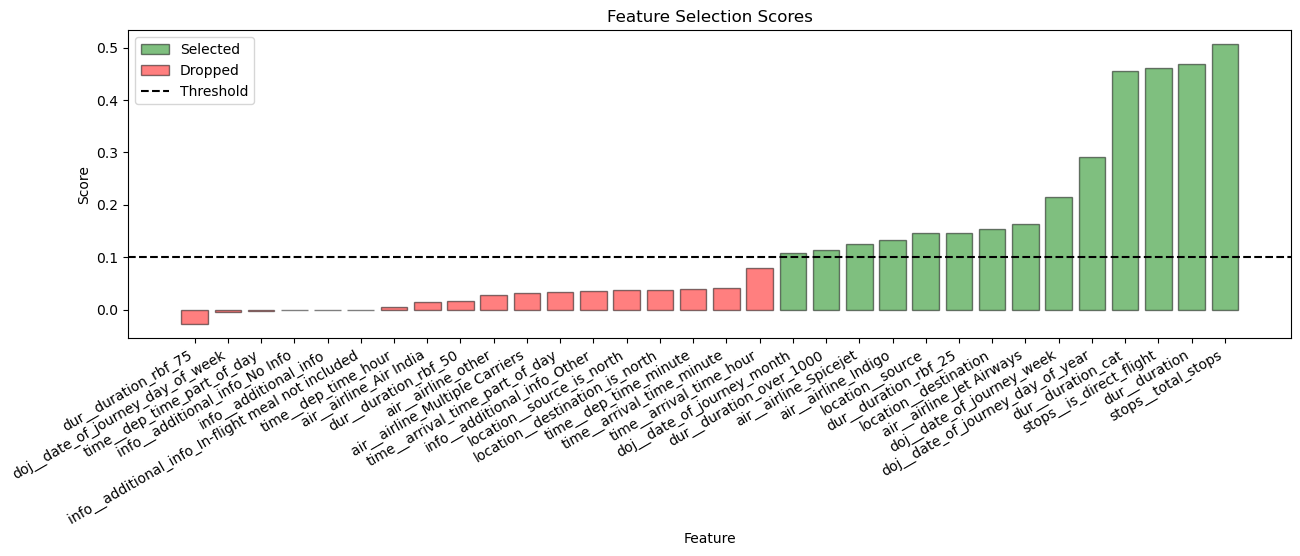

In [138]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)
plt.show()